In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

poster = True
figscale = 1.75 if poster else 1.0

sns.set_theme(
    context="poster" if poster else "paper",
    style="whitegrid",
    rc={
        "figure.figsize": (figscale * 3.5, figscale * 3.5),
        "figure.dpi": 150,
        "savefig.dpi": 1000,
        # "figure.constrained_layout.use": True,
        "pdf.fonttype": 42,
    },
)

In [11]:
data_path = Path("/nfs/general/mid_data/stats")
filenames = list(data_path.glob("*.npy"))
# filenames = [data_path / "256.npy", data_path / "512.npy"]


def load_scale(filename: Path) -> pd.DataFrame:
    # filename of form {img_size}.npy
    img_size = int(filename.stem)
    data = np.load(filename)
    # columns of data: opt_conn, cnn_conn, cnn_power, opt_count, cnn_count, avg_power
    # keep only the ones relating to cnn
    return pd.DataFrame(
        {
            "img_size": img_size,
            "connectivity": data[:, 1],
            "power": data[:, 2],
            "n_comm": data[:, 4],
        }
    )


df = pd.concat([load_scale(f) for f in filenames], axis=0, ignore_index=True)

# remove values with power == 0
df = df[df["power"] > 0]

df.head()

,img_size,connectivity,power,n_comm
1,768,-4.753953e-17,23.113038,178.0
2,768,-6.193376e-18,16.529586,156.0
3,768,-9.556829e-18,16.187281,163.0
4,768,-1.727234e-17,16.120246,171.0
5,768,-1.792509e-17,18.372750,182.0


In [12]:
display(df.groupby("img_size")["power"].describe()[["mean", "std"]].round(2))
display(df.groupby("img_size")["n_comm"].describe()[["mean", "std"]].round(2))

,mean,std
img_size,,
256,16.60,3.21
512,18.30,4.54
768,18.27,2.71
1024,18.48,2.06
1280,18.03,1.37


,mean,std
img_size,,
256,12.57,3.52
512,68.75,11.30
768,165.79,16.20
1024,308.85,20.70
1280,494.24,27.63


In [13]:
meters_per_pixel = 1.25
df["width"] = (df["img_size"] * 1.25).astype(int)

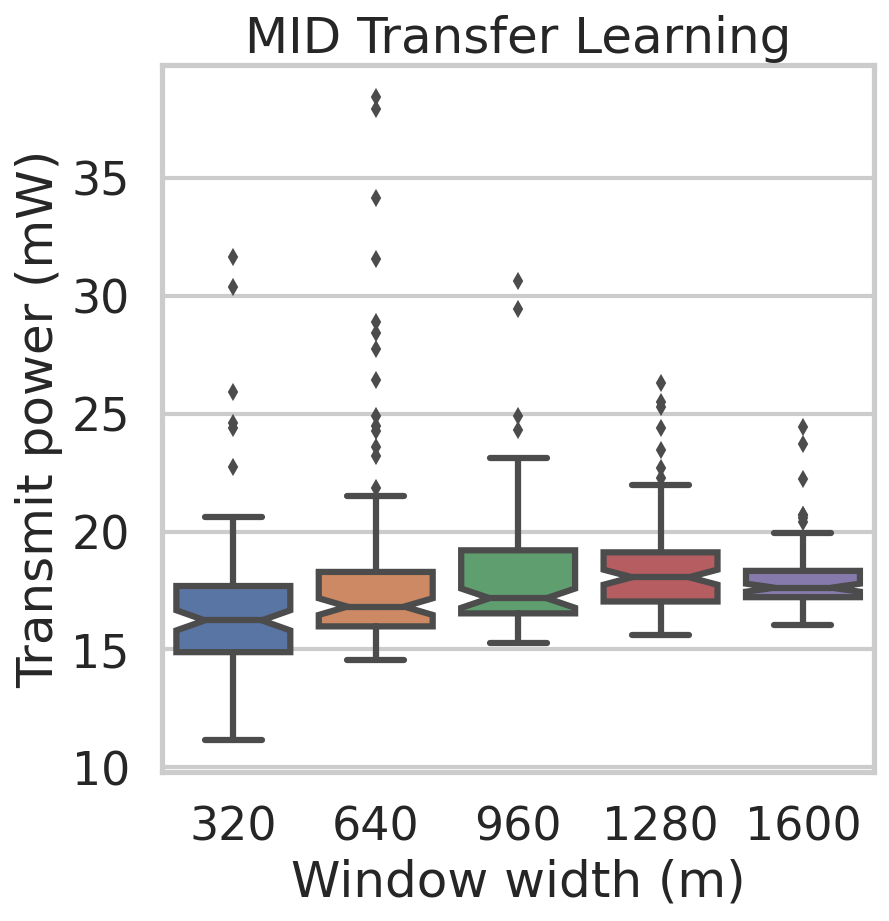

In [17]:
sns.boxplot(data=df, x="width", y="power", notch=True)
plt.xlabel("Window width (m)")
plt.ylabel("Transmit power (mW)" if poster else "Average minimum transmit power (mW)")
if poster:
    plt.title("MID Transfer Learning")
plt.savefig("../figures/mid_power.pdf", bbox_inches="tight")
plt.savefig("../figures/mid_power.png", bbox_inches="tight")
plt.show()

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

df_baseline = pd.read_csv("../data/baseline.csv")
agents = df_baseline["agents"].to_numpy()
time = df_baseline["time"].to_numpy()

# Fit a Polynomial Model
params_poly = np.polyfit(agents, time, deg=3)
time_poly = np.polyval(params_poly, agents)


# Fit an Exponential Model
def exp_model(x, a, b, c):
    return a * np.power(x, b) + c


params_power, _ = curve_fit(exp_model, agents, time, p0=[1, 1e-6, 1])
time_power = exp_model(agents, *params_power)

plt.figure()
plt.title("MID Convex Optimization Computation Time")
plt.xlabel("Total Agents")
plt.ylabel("Time (s)")
plt.plot(agents, time, "o", label="Data")
plt.plot(agents, time_poly, label="Polynomial Fit")
plt.plot(agents, time_power, label="Power Fit")
plt.legend()
plt.show()

In [ ]:
df_baseline["time_poly"] = time_poly
df_baseline["time_power"] = time_power
# compute residuals
for model in ["poly", "power"]:
    df_baseline[f"residual_{model}"] = (
        df_baseline["time"] - df_baseline[f"time_{model}"]
    )
print(params_power)
df_baseline.filter(regex="residual_").pow(2).mean()
# Extrapolate to 600 agents
agents_extrapolate = np.array([10, 50, 100, 300, 600])
time_poly_extrapolate = np.polyval(params_poly, agents_extrapolate)
time_exp_extrapolate = exp_model(agents_extrapolate, *params_power)

plt.figure()
plt.title("Extrapolation of Computation Time")
plt.xlabel("Total Agents")
plt.ylabel("Time (minutes)")
plt.plot(agents_extrapolate, time_poly_extrapolate / 60**2, label="Polynomial")
plt.plot(agents_extrapolate, time_exp_extrapolate / 60**2, label="Power")
plt.show()

print("Extrapolated Runtime in Minutes")
pd.DataFrame(
    dict(
        agents=agents_extrapolate,
        poly=time_poly_extrapolate / 60,
        power=time_exp_extrapolate / 60,
    )
)